 YAPACAĞIMIZ İŞLEM FEATURE ENGİNEERİNG VE MACHİNE LEARNİNG
 TİTANİC VERİSETİNDE İNSANLARIN HAYATTA KALIP KALAMAYACAĞINI BU VERİ SETİ ÜZERİNDEN MODELLİYECEĞİZ.

# KÜTÜPHANELER

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


# VERİSETİ

In [ ]:
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


# 1) FEATURE ENGİNEERİNG

In [ ]:
# öncelikle değişken isimleri küçük bunlarıbüyük formata getirelim.
df.columns = [col.upper() for col in df.columns]

In [ ]:
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')

# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()

# Name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

# Name Dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

# Name title
df["NEW_TITLE"] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)

# Family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

# Age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

# Is alone(kişi yalnız mı değil mi)
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"

# Age level(Yaşlarına göre değişken)
df.loc[(df["AGE"] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df["AGE"] >= 56), 'NEW_AGE_CAT'] = 'senior'

# Sex x Age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'


In [ ]:
df.head(3)

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,maturefemale


In [ ]:
df.shape

(891, 22)

In [ ]:
# VERİ SETİNİ DÜZENLEME GRAB_COL_NAMES

def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [ ]:
# "PASSANGERID" değişkeni işimize yaramadığı için verisetimizden çıkaralım
num_cols = [col for col in num_cols if col not in "PASSENGERID"]

In [ ]:
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

# 2) OUTLİERS - AYKIRI DEĞERLER

In [ ]:
# 1) Eşik değerlerini hesaplama fonk.(IQR)
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit


In [ ]:
# 2) Verisetimizde aykırı değer varmı yokmukontrol edelim (check_outlier fonksiyonu)
def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis = None):
    return True
  else:
    return False


In [ ]:
# verimizi check edelim
# görünene göre 4 değişkenimiz aykırı değer içeriyor
for col in num_cols:
  print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [ ]:
# 3) Aykırı değerleri silmeyelim eşik değerleriyle aykırı değerleri değiştirelim (replace_with_thresholds)
def replace_with_thresholds(dataframe,veriable):
  low_limit, up_limit = outlier_thresholds(dataframe, veriable)
  dataframe.loc[(dataframe[veriable] < low_limit), veriable] = low_limit
  dataframe.loc[(dataframe[veriable] > up_limit), veriable] = up_limit

In [ ]:
for col in num_cols:
  replace_with_thresholds(df, col)

In [ ]:
# tekrar bir check edelim bakalım aykırı değerler var mı hala yoksa işlem olmuş mu
# outlier işlemi tamamdır.
for col in num_cols:
  print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


# 3) MISSING VALUES - BOŞ DEĞERLER

In [ ]:
# 1) eksik değerleri yakalama fonk.
def missing_values_table(dataframe, na_name=False):
  # dataframe'den sadece eksik olan kolonları seç
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  # eksikliğe sahip olan değişkenlerin toplamını al sırala
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  # oranlarını hesaplma
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  # yukarıda yapılan işlemleri missing_df adında birleştir
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end = "\n")
  if na_name:
    return na_columns

In [ ]:
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


In [ ]:
# öncelikle CABIN değişkenimiz için en başta yeni bir değişken oluşturmuştuk bunu silebiliriz.
df.drop("CABIN", inplace=True, axis=1)

In [ ]:
# yukarıdaki işlemin aynısını TICKET VE NAME değişkenlerimize yapalım bunlarada yeni değişken oluşturmuştuk.
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)

In [ ]:
missing_values_table(df)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220


In [ ]:
# AGE'li değişkenlerde boş değer çok çünkü age ve embarked haricindeki değişkenleri AGE değişkeni üzerinden türettiğimiz için
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [ ]:

# Age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

# Age level(Yaşlarına göre değişken)
df.loc[(df["AGE"] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df["AGE"] >= 56), 'NEW_AGE_CAT'] = 'senior'

# Sex x Age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [ ]:
missing_values_table(df)

          n_miss  ratio
EMBARKED       2  0.220


In [ ]:
# Sadece boş değeri olan EMBARKED değişkeni kaldı bunu düzeltelim
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [ ]:
missing_values_table(df)
# eksik değer probleminden tamamıyla kurtulduk.

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


# 4) ENCODİNG SCALİNG

LABEL ENCODİNG

In [ ]:
#2 sınıflı kategorik  değişkenleri 0-1 olarak dönüştürme işlemi
# 2 sınıflı olankategorikdeğişkenleriseçelim
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

In [ ]:
binary_cols

['SEX', 'NEW_IS_ALONE']

In [ ]:
# yukarıdagördüğümüz gibi 2 sınıflı 2 adet kategorik değişkenimiz var bunlarılael_encoder fonk. geçirelim.
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe


In [ ]:
for col in binary_cols:
  label_encoder(df, col)

In [ ]:
df[binary_cols].head(3)

,SEX,NEW_IS_ALONE
0,1,0
1,0,0
2,0,1


RARE ENCODİNG

In [ ]:
# önce rare anlyser fonk yazalım
def rare_analyser(dataframe, target, cat_cols):
  for col in cat_cols:
    print(col, ":", len(dataframe[col].value_counts()))
    print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                        "RATIO": dataframe[col].value_counts() / len(dataframe),
                        "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end= "\n\n\n")


In [ ]:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


EMBARKED : 3
          COUNT  RATIO  TARGET_MEAN
EMBARKED                           
C           168  0.189        0.554
Q            77  0.086        0.390
S           646  0.725        0.339


NEW_TITLE : 17
           COUNT  RATIO  TARGET_MEAN
NEW_TITLE                           
Capt           1  0.001        0.000
Col            2  0.002        0.500
Countess       1  0.001        1.000
Don            1  0.001        0.000
Dr             7  0.008        0.429
Jonkheer       1  0.001        0.000
Lady           1  0.001        1.000
Major          2  0.002        0.500
Master        40  0.045        0.575
Miss         182  0.204        0.698
Mlle           2  0.002        1.000
Mme            1  0.001        1.000
Mr           517  0.580        0.157
Mrs          125  0.140        0.792
Ms             1  0.001        1.000
Rev            6  0.007    

In [ ]:
# rare encoder fonk. çözüm kısmı(bitiş)
def rare_encoder(dataframe, rare_perc):
  temp_df = dataframe.copy()
  rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O"
  and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

  for var in rare_columns:
    tmp = temp_df[var].value_counts() / len(temp_df)
    rare_labels = tmp[tmp < rare_perc].index
    temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df


In [ ]:
df = rare_encoder(df, 0.01)

In [ ]:
# kontrol edelim sınıflar temizlendi mi diyem
# mesela "NEW_TITLE" değişkenimizde önemsiz sınıflar "rare" sınıfı adı altında bir araya gelmiş.
df["NEW_TITLE"].value_counts()

NEW_TITLE
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

ONE HOT ENCODİNG

In [ ]:
# veri setindeki bütün kategorik değişkenleri çevirmemiz lağzım
# one hot encoding işlemine tabi tutulacaksütunları deçelim
ohe_cols = [col for col in df.columns if 10>= df[col].nunique() > 2 ]
# 2 den fazla eşsiz değere sahip olan değişkenler ve 10 danküçük sayıda eşsizi olan değişkenleri getirelim

In [ ]:
# one hot encoder fonk. yazalım
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
  dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
  return dataframe

In [ ]:
df = one_hot_encoder(df, ohe_cols)

In [ ]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.000,7.250,0,23,0,66.000,0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,2,1,0,38.000,65.634,1,45,0,38.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1,0,26.000,7.925,0,22,0,78.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.000,53.100,1,44,0,35.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,0,1,35.000,8.050,0,24,0,105.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


 MODELLEMEYE HAZIR OLUP OLMAMASI (SON KISIM)

In [ ]:
# grab fonk. çağıralım
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47


In [ ]:
# passengerid değişkenlerimizden çıkaralım tekrar
num_cols = [col for col in df.columns if "PASSENGERID" not in col]

In [ ]:
# rare analyser fonk. geçirip kontrol edelim
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
          COUNT  RATIO  TARGET_MEAN
SURVIVED                           
0           549  0.616        0.000
1           342  0.384        1.000


SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


NEW_CABIN_BOOL : 2
                COUNT  RATIO  TARGET_MEAN
NEW_CABIN_BOOL                           
0                 687  0.771        0.300
1                 204  0.229        0.667


NEW_NAME_DR : 2
             COUNT  RATIO  TARGET_MEAN
NEW_NAME_DR                           
0              881  0.989        0.383
1               10  0.011        0.500


NEW_IS_ALONE : 2
              COUNT  RATIO  TARGET_MEAN
NEW_IS_ALONE                           
0               354  0.397        0.506
1               537  0.603        0.304


PCLASS_2 : 2
          COUNT  RATIO  TARGET_MEAN
PCLASS_2                           
False       707  0.793        0.361
True        184  0.207        0.473


PCLASS

In [ ]:
# yeni bir problemimiz var 2 sınıflı olup sınıflarından herhangi birtanesi 0.01'den az olan değişken var mı
useless_cols = [col for col in df.columns if df[col].nunique() ==  2 and (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

In [ ]:
useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [ ]:
# son olarak bu gereksiz değişkenleri silme işlemi yapalım
df.drop(useless_cols, axis=1, inplace=True)

In [ ]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,PARCH_1,PARCH_2,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.000,7.250,0,23,0,66.000,0,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
1,2,1,0,38.000,65.634,1,45,0,38.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1,0,26.000,7.925,0,22,0,78.000,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.000,53.100,1,44,0,35.000,0,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,5,0,1,35.000,8.050,0,24,0,105.000,1,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


# 5) MODEL OLUŞTURMA(MACHİNE LEARNİNG)

In [ ]:
# öneclikle bağımlı değişkenimizi yazalım
y = df["SURVIVED"]
# şimdi bağımsız değişkenlerimizi yazalım bunun kolay yoluda bağımlı değişkenleri atayacağımız x değişkeninden çıkarmak
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

In [ ]:
# train ve test işlemleri
# verimizi iki'ye ayırıyoruz
# train seti üzerinde model kuracağız, test seti ile kurduğumuz modeli test ediyor olacağız.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [ ]:
# şimdi model nesnemizi getirelim
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# modeli kuralım
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)
# %80 accuracy_score(doğruluk oranı)
# peki sonuç nedir
# bu gemiye kişiler binmeden önce bilgilerini verip bu modele sorsaydık gemiye bineceklerin %80'nin hayatta kalıp kalamayacağını doğru tahmin eerdik. :)

0.8097014925373134

In [ ]:
# bir çok yeni değişken türettik bakalım bunlar ne durumda bize neleri göstermiş hangileri hayatta kalma konusunda önem arz ediyor.
# şimdi plot_importance adında bir fonk. varbu model bütün değişkenlerin grafik şeklinde önemlerini vurguluyor.

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


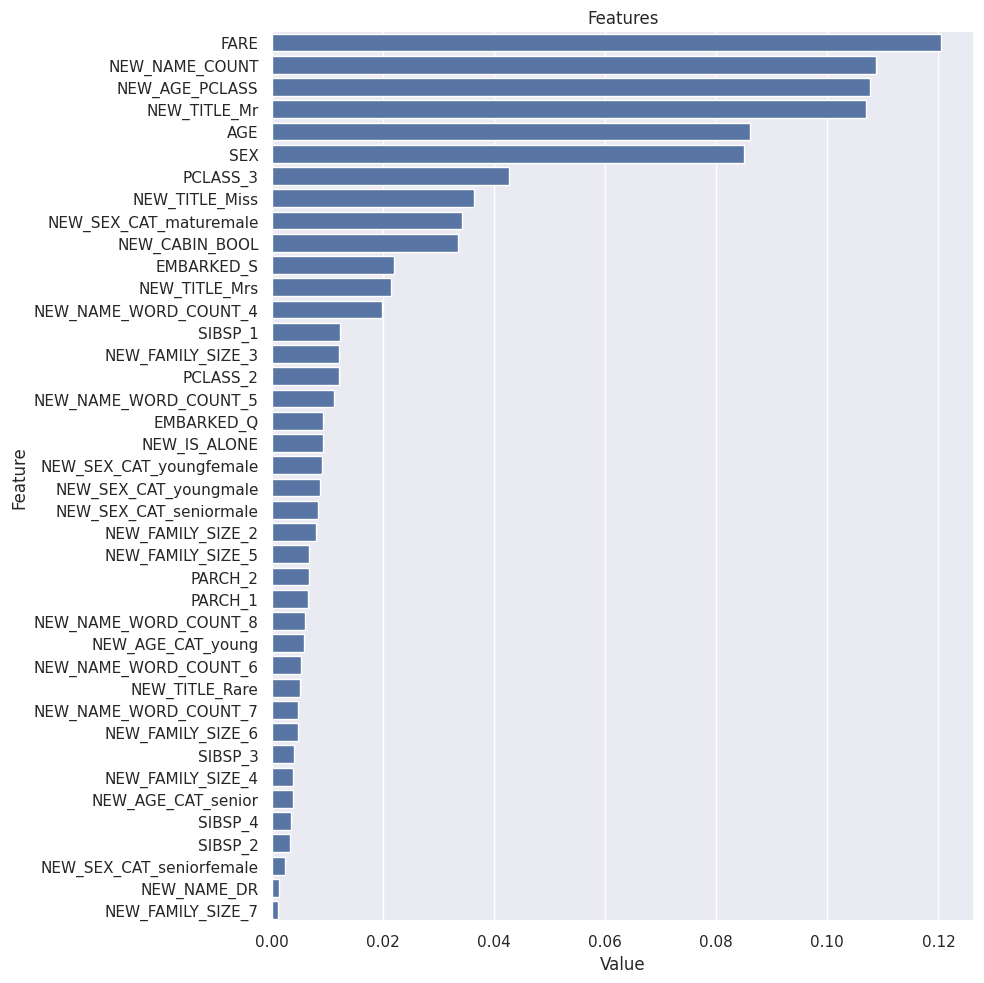

In [ ]:
plot_importance(rf_model, X_train)

In [ ]:
# en önemli değişkenler isimler, fare(bilet ücretleri), yeni oluşturduğumuz çoğu değişken hatta Mr(title)'lar bile en önemli değişken.